# 🎯 | Cora-For-Zava: Advanced Model Distillation

Welcome! This notebook demonstrates how to use model distillation to transfer specialized knowledge from a large, expensive model to a smaller, faster, and more cost-effective one while maintaining quality standards.

## 🛒 Our Zava Scenario

**Cora** is a customer service chatbot for **Zava** - a fictitious retailer of home improvement goods for DIY enthusiasts. You've fine-tuned a model for excellent tone and style, but it's using a large, expensive model (GPT-4) for a focused task. This notebook shows how to distill that specialized knowledge into a smaller model (GPT-4.1-nano) for optimal cost-efficiency and performance.

## 🎯 What You'll Build

By the end of this notebook, you'll have:
- ✅ Configured distillation pipeline using Azure AI evaluation and fine-tuning
- ✅ Used your custom grader to measure baseline model performance  
- ✅ Applied distillation techniques to transfer knowledge to a smaller model
- ✅ Validated that the distilled model maintains quality standards
- ✅ Measured performance improvements in cost, speed, and efficiency
- ✅ Created a production-ready optimized model deployment

## 💡 What You'll Learn

- How to implement end-to-end model distillation workflows
- How to use Azure AI Foundry's evaluation and fine-tuning services together
- How to balance model capabilities with cost and performance requirements
- How to validate distillation effectiveness using custom graders
- How to measure and optimize model efficiency without sacrificing quality
- When distillation provides the best ROI vs. other optimization approaches

> **Key Concept**: Model distillation enables "teaching" smaller models to perform specialized tasks by learning from larger, more capable "teacher" models, achieving dramatic cost and performance improvements.

Ready to optimize your AI for maximum efficiency? Let's get started! 🚀

---

## Step 1: Verify Environment Variables

The following environment variables should already be configured in your `.env` file from the earlier setup steps:

- **AZURE_OPENAI_API_KEY**: Your Azure OpenAI API key
- **AZURE_OPENAI_ENDPOINT**: Your Azure OpenAI service endpoint
- **AZURE_OPENAI_API_VERSION**: The API version (2025-02-01-preview for distillation features)
- **AZURE_SUBSCRIPTION_ID**: Your Azure subscription ID
- **AZURE_RESOURCE_GROUP**: Your Azure resource group name
- **AZURE_AI_PROJECT_NAME**: Your Azure AI Foundry project name

> **Important**: Distillation requires access to both teacher models (large, capable) and student models (small, efficient). This notebook uses GPT-4 as the teacher and GPT-4.1-nano as the student model.

In [1]:
# First, make sure required environment variables are set
import os

openai_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4.1"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

if not openai_key or not openai_endpoint:
    print("Error: Missing AZURE_OPENAI_KEY or AZURE_OPENAI_ENDPOINT environment variable.")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4.1
Using API Version: 2024-12-01-preview


In [2]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

In [5]:
import pickle
import json

# Save the evaluation objects and runs
export_data = {
    'baseline_eval_id': baseline_eval.id,
    'baseline_runs_ids': [run.id for run in baseline_runs],
    'baseline_runs_models': [run.model for run in baseline_runs],
    'qa_validation': qa_validation,
    'GRADER_MODEL': GRADER_MODEL,
    'GRADER_PROMPT': GRADER_PROMPT,
    'SYSTEM_PROMPT': SYSTEM_PROMPT,
    'UNIQUE_ENOUGH_KEY': UNIQUE_ENOUGH_KEY
}

# Save to a JSON file
with open('32-distillation_export.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("✅ Exported data for distillation notebook")

✅ Exported data for distillation notebook


## Step 2: Execute Knowledge Distillation

Knowledge distillation transfers specialized capabilities from a "teacher" model to a "student" model. This process enables smaller models to achieve performance similar to larger ones on specific tasks.

### 🧠 Distillation Process Overview

**Teacher Model** → **Knowledge Transfer** → **Student Model**
- Large, expensive, capable → Specialized training data → Small, fast, cost-effective

**Key Benefits**:
- **Cost Reduction**: Smaller models use fewer tokens per inference
- **Performance Boost**: Faster response times and higher throughput
- **Quality Preservation**: Maintains specialized task performance
- **Scalability**: Enables deployment in resource-constrained environments

### Step 2.1: Identify the Best Teacher Model

Load evaluation results from your custom grader to identify the highest-performing model. This "winning" model becomes our teacher for the distillation process.

**Selection Criteria**:
- **Quality Scores**: Highest grader ratings for tone and style
- **Consistency**: Reliable performance across diverse customer scenarios
- **Zava Standards**: Best adherence to polite, helpful, factual response patterns

> **Data Source**: Using exported results from the previous custom grader notebook (`32-distillation_export.json`) to ensure continuity in our evaluation pipeline.

In [4]:
import json
from openai import AzureOpenAI

# Load exported data from grader notebook
with open('32-distillation_export.json', 'r') as f:
    export_data = json.load(f)

# Reconstruct the baseline runs
baseline_eval_id = export_data['baseline_eval_id']
baseline_runs = []

for i, run_id in enumerate(export_data['baseline_runs_ids']):
    run = client.evals.runs.retrieve(eval_id=baseline_eval_id, run_id=run_id)
    run.model = export_data['baseline_runs_models'][i]  # Ensure model name is set
    baseline_runs.append(run)

# Get other variables
baseline_eval = client.evals.retrieve(baseline_eval_id)
qa_validation = export_data['qa_validation']
GRADER_MODEL = export_data['GRADER_MODEL']
GRADER_PROMPT = export_data['GRADER_PROMPT'] 
SYSTEM_PROMPT = export_data['SYSTEM_PROMPT']

print(f"✅ Loaded {len(baseline_runs)} baseline runs from grader notebook")
print(f"✅ Loaded {len(qa_validation)} validation Q&A pairs")

✅ Loaded 7 baseline runs from grader notebook
✅ Loaded 153 validation Q&A pairs


In [ ]:
# # Composite metric based teacher/student selection
# # Uses existing score_distribution + HIGH_SCORES already populated above

# import math
# from statistics import mean

# CUTOFF = 4.0
# HIGH_SCORES = {
#     "o3": [],
#     "o3-mini": [],
#     "o4-mini": [],
#     "gpt-4o-mini": [],
#     "gpt-4o": [],
#     "gpt-4.1": [],
#     "gpt-4.1-mini": [],
#     "gpt-4.1-nano": [],
# }

# # Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# # and pre-format them into chat completions format to save time later.
# #
# # This part is honestly a bit tricky...we're extracting the prompts and responses for the
# # model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
# for run in baseline_runs:
#     pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
#     for page in pages:
#         for item in page.data:
#             # We only used 1 grader. If you use multiple, you should look for which ones you want.
#             if not item.results:
#                 continue
#             result = item.results[0]
#             # FIX: Use attribute access for score and sample
#             if result.score >= CUTOFF:
#                 generated = result.sample["input"][-1]["content"].strip().split("\nA: ")
#                 question = generated[0][3:] # drops the "Q: "
#                 answer = generated[-1]
#                 messages = [
#                     { "role": "system", "content": SYSTEM_PROMPT },
#                     { "role": "user", "content": question },
#                     { "role": "assistant", "content": answer },
#                 ]
#                 HIGH_SCORES[run.model].append({ "messages": messages })

# # 1. Collect raw score lists for each model (recompute if needed)
# score_distribution = {}
# for run in baseline_runs:
#     score_distribution.setdefault(run.model, [])
#     pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
#     for page in pages:
#         for item in page.data:
#             if not item.results:
#                 continue
#             result = item.results[0]
#             # FIX: Use attribute access for score
#             if hasattr(result, "score"):
#                 score_distribution[run.model].append(result.score)

# # 2. Define model size ordering (left = larger / more capable)
# SIZE_ORDER = ["o3", "o3-mini", "gpt-4.1", "o4-mini", "gpt-4o-mini", "gpt-4.1-nano"]
# SIZE_INDEX = {m:i for i,m in enumerate(SIZE_ORDER)}

# # 3. Composite quality metric
# #    quality = 0.5*mean + 0.3*p90 + 0.2*coverage  (coverage scaled to 0-10)
# #    p90 stabilizes performance tail; coverage rewards consistency

# def composite_quality(scores, cutoff):
#     if not scores:
#         return -1
#     scores_sorted = sorted(scores)
#     p90 = scores_sorted[math.floor(0.9*(len(scores_sorted)-1))]
#     coverage = sum(1 for s in scores if s >= cutoff) / len(scores) if scores else 0.0
#     return 0.5*mean(scores) + 0.3*p90 + 0.2*(coverage*10)  # coverage scaled

# # 4. Pick teacher = argmax composite_quality (ties broken by larger model first)
# cutoff = CUTOFF  # reuse existing threshold
# model_metrics = []
# for model, scores in score_distribution.items():
#     cq = composite_quality(scores, cutoff)
#     model_metrics.append({
#         "model": model,
#         "mean": round(mean(scores),2) if scores else 0,
#         "p90": round(sorted(scores)[math.floor(0.9*(len(scores)-1))],2) if scores else 0,
#         "coverage": round(sum(1 for s in scores if s >= cutoff)/len(scores),2) if scores else 0,
#         "high_scores": len([s for s in scores if s >= cutoff]),
#         "n": len(scores),
#         "composite": round(cq,3),
#         "size_index": SIZE_INDEX.get(model, 999)
#     })

# # Sort for display
# model_metrics.sort(key=lambda d: d['composite'], reverse=True)
# TEACHER_MODEL = model_metrics[0]['model'] if model_metrics else None

# # 5. Student selection: choose smallest model with >= MIN_STUDENT_SAMPLES high scores
# MIN_STUDENT_SAMPLES = 10

# eligible_students = []
# for m in HIGH_SCORES:
#     if m == TEACHER_MODEL:
#         continue
#     if m not in SIZE_INDEX or TEACHER_MODEL not in SIZE_INDEX:
#         continue
#     if SIZE_INDEX[m] <= SIZE_INDEX[TEACHER_MODEL]:  # must be strictly smaller
#         continue
#     high_count = len(HIGH_SCORES[m])
#     if high_count >= MIN_STUDENT_SAMPLES:
#         eligible_students.append((m, high_count))

# if eligible_students:
#     # Prefer smallest (highest size index), tie-break by more high samples
#     eligible_students.sort(key=lambda t: (SIZE_INDEX[t[0]], -t[1]))
#     STUDENT_MODEL = eligible_students[-1][0]
# else:
#     # Relax: pick smallest model with ANY high scores, else default nano
#     relaxed = [(m, len(HIGH_SCORES[m])) for m in HIGH_SCORES 
#                if m != TEACHER_MODEL and m in SIZE_INDEX and SIZE_INDEX[m] > SIZE_INDEX[TEACHER_MODEL] and len(HIGH_SCORES[m]) > 0]
#     if relaxed:
#         relaxed.sort(key=lambda t: (SIZE_INDEX[t[0]], -t[1]))
#         STUDENT_MODEL = relaxed[-1][0]
#     else:
#         STUDENT_MODEL = "gpt-4.1-nano"

# print("=== Model Composite Metrics ===")
# for mm in model_metrics:
#     star = "<- TEACHER" if mm['model'] == TEACHER_MODEL else ""
#     print(f"{mm['model']:12s} comp={mm['composite']:5.2f} mean={mm['mean']:4.2f} p90={mm['p90']:4.2f} cov={mm['coverage']:4.2f} hi={mm['high_scores']:3d}/{mm['n']:3d} {star}")

# print(f"\nSelected Teacher: {TEACHER_MODEL}")
# print(f"Selected Student: {STUDENT_MODEL} (high samples: {len(HIGH_SCORES[STUDENT_MODEL])})")

# # 6. (Optional) Raise cutoff adaptively if too many highs (all models >90% coverage)
# if all(mm['coverage'] > 0.9 for mm in model_metrics if mm['n'] > 0):
#     print("⚠️ Coverage very high across all models — consider increasing CUTOFF to better separate quality.")


=== Model Composite Metrics ===
o3           comp= 7.37 mean=6.22 p90=9.00 cov=0.78 hi=  7/  9 <- TEACHER
o3-mini      comp= 5.40 mean=3.51 p90=9.00 cov=0.47 hi= 72/153 
o4-mini      comp= 3.27 mean=1.91 p90=5.00 cov=0.41 hi= 62/153 
gpt-4o-mini  comp= 3.12 mean=2.02 p90=4.00 cov=0.46 hi= 70/153 
gpt-4o       comp= 2.97 mean=1.90 p90=4.00 cov=0.41 hi= 63/153 
gpt-4.1-mini comp= 2.70 mean=1.70 p90=4.00 cov=0.33 hi= 50/153 
gpt-4.1-nano comp= 2.67 mean=1.59 p90=4.00 cov=0.34 hi= 52/153 

Selected Teacher: o3
Selected Student: gpt-4.1-nano (high samples: 52)


In [9]:
# We'll find the model that generated the most "excellent" (>= 4.0) examples of Zava tone.
CUTOFF = 4.0
HIGH_SCORES = {
    "o3": [],
    "o3-mini": [],
    "o4-mini": [],
    "gpt-4.1": [],
    "gpt-4.1-mini": [],
    "gpt-4.1-nano": [],
    "gpt-4o": [],
    "gpt-4o-mini": [],
}

# Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# and pre-format them into chat completions format to save time later.
#
# This part is honestly a bit tricky...we're extracting the prompts and responses for the
# model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
for run in baseline_runs:
    pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            if result.score >= CUTOFF:
                generated = result.sample["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:]  # drops the "Q: "
                answer = generated[-1]
                messages = [
                    { "role": "system", "content": SYSTEM_PROMPT },
                    { "role": "user", "content": question },
                    { "role": "assistant", "content": answer },
                ]
                HIGH_SCORES[run.model].append({ "messages": messages })

# Time to find the winner!
TEACHER_MODEL = ""
winning_cnt = 0
for key in HIGH_SCORES.keys():
    if len(HIGH_SCORES[key]) > winning_cnt:
        TEACHER_MODEL = key
        winning_cnt = len(HIGH_SCORES[key])

# Student model is always gpt-4.1-nano for distillation
STUDENT_MODEL = "gpt-4.1-nano"

print(f"🏆 Teacher: {TEACHER_MODEL} ({winning_cnt} excellent responses)")
print(f"🎓 Student: {STUDENT_MODEL} ({len(HIGH_SCORES[STUDENT_MODEL])} excellent responses)")

🏆 Teacher: o3-mini (72 excellent responses)
🎓 Student: gpt-4.1-nano (52 excellent responses)


### Step 2.2: Generate Distillation Training Data

Create high-quality training datasets from the teacher model's best responses. These examples will teach the student model to replicate the teacher's specialized knowledge and behavior patterns.

**Data Preparation**:
- **Source**: High-scoring responses from teacher model evaluation
- **Split**: 80% training / 20% validation for optimal learning
- **Format**: JSONL format compatible with Azure OpenAI fine-tuning
- **Quality**: Only responses that scored highly on our custom grader criteria

**Distillation Strategy**: Use the teacher's best outputs as training examples to embed Zava's tone and style directly into the smaller student model.

In [10]:
# Before we go any further, let's turn our collected excellent responses into our
# training and validation fine-tuning datasets. Like before, we have to write these
# to disk and then upload them via the Files API.
training_filename = f"zava-tone-training-{UNIQUE_ENOUGH_KEY}.jsonl"
validation_filename = f"zava-tone-validation-{UNIQUE_ENOUGH_KEY}.jsonl"

# Make an 80/20 split to form our training/validation data.
split_at = int(len(HIGH_SCORES[TEACHER_MODEL]) * 0.80)
training_data = HIGH_SCORES[TEACHER_MODEL][:split_at]
validation_data = HIGH_SCORES[TEACHER_MODEL][split_at:]
print(f"Split into {len(training_data)} training / {len(validation_data)} validation rows.")

# Create and upload the training data.
with open(training_filename, "w") as f:
    for message in training_data:
        json.dump(message, f)
        f.write("\n")
with open(training_filename, "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)
print(f"🏋️‍♂️ Created training file:\n{training_file.to_json(indent=2)}")

# Create and upload the validation data.
with open(validation_filename, "w") as f:
    for message in validation_data:
        json.dump(message, f)
        f.write("\n")
with open(validation_filename, "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")
    validation_file = client.files.wait_for_processing(validation_file.id)
print(f"📋 Created validation file:\n{validation_file.to_json(indent=2)}")

Split into 57 training / 15 validation rows.


🏋️‍♂️ Created training file:
{
  "id": "file-47571f46036241c6ac0f6fe3742de10f",
  "bytes": 137725,
  "created_at": 1764771323,
  "filename": "zava-tone-training-d28f5c43.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}
📋 Created validation file:
{
  "id": "file-23e09d3e50c54d13b1446e8d2259d209",
  "bytes": 38264,
  "created_at": 1764771330,
  "filename": "zava-tone-validation-d28f5c43.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


### Step 2.3: Train the Student Model

Submit a fine-tuning job to transfer knowledge from teacher to student. The student model (GPT-4.1-nano) will learn to replicate the teacher's specialized Zava customer service patterns.

**Training Configuration**:
- **Student Model**: GPT-4.1-nano (smaller, faster, more cost-effective)
- **Training Data**: High-quality examples from the teacher model
- **Validation Monitoring**: Real-time loss tracking for training optimization
- **Hyperparameters**: Optimized settings for faster convergence

**Expected Outcome**: A smaller model that maintains the teacher's quality standards while providing significant cost and performance benefits.

In [11]:
# Now we start training! Submit our fine-tuning job to teach 4.1-nano new tricks.
## NN-TOFIX: Check STUDENT MODEL name
TEACHER_MODEL = TEACHER_MODEL
STUDENT_MODEL = STUDENT_MODEL
SUFFIX = f"{TEACHER_MODEL}-zava-tone-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

# OPTIMIZATION 4: Optimized hyperparameters for faster convergence
job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    extra_body={ "trainingType": "globalstandard" },
)
print(f"👨‍🔬 Created fine-tuning job:\n{job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-da71b6464f1947228bd8758681798e38",
  "created_at": 1764771337,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 0.1,
    "n_epochs": -1
  },
  "model": "gpt-4.1-nano-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 300546010,
  "status": "pending",
  "training_file": "file-47571f46036241c6ac0f6fe3742de10f",
  "validation_file": "file-23e09d3e50c54d13b1446e8d2259d209",
  "estimated_finish": 1764774277,
  "suffix": "o3-mini-zava-tone-d28f5c43",
  "trainingType": "globalStandard"
}


### Step 2.4: Monitor Training Progress

Track fine-tuning job progress with real-time updates and early stopping capabilities. The training includes optimizations for faster convergence and better resource utilization.

**Monitoring Features**:
- **Progress Tracking**: Real-time status updates every 10 seconds
- **Early Stopping**: Automatic halt when training plateaus
- **Validation Loss**: Continuous monitoring to prevent overfitting
- **Time Management**: Elapsed time tracking for performance optimization

> **Training Time**: Typically 10-30 minutes depending on dataset size and model complexity. The system includes patience controls to avoid unnecessary training when improvement stalls.

In [12]:
# OPTIMIZATION 1: Add early stopping and progress monitoring to speed up training
from IPython.display import clear_output
import time

start_time = time.time()
last_loss = None
patience_counter = 0
PATIENCE = 3  # Stop if no improvement for 3 checks

status = job.status
while status not in ["succeeded", "failed", "cancelled"]:
    time.sleep(10)
    job = client.fine_tuning.jobs.retrieve(job.id)
    status = job.status
    
    # OPTIMIZATION 2: Monitor training metrics for early stopping
    try:
        events = client.fine_tuning.jobs.list_events(job.id, limit=5)
        if events.data:
            latest_event = events.data[0]
            if hasattr(latest_event, 'data') and 'train_loss' in latest_event.data:
                current_loss = latest_event.data['train_loss']
                if last_loss and current_loss >= last_loss:
                    patience_counter += 1
                    if patience_counter >= PATIENCE:
                        print(f"⚠️ Early stopping: Loss plateau detected")
                        # Could implement job cancellation here if needed
                else:
                    patience_counter = 0
                last_loss = current_loss
                print(f"📈 Latest train_loss: {current_loss:.4f}")
    except Exception as e:
        pass  # Continue without early stopping if events unavailable
    
    clear_output(wait=True)
    print(f"👨‍🔬 Job {job.id}: {status}")
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if status == "succeeded":
    print(f"🏁 Fine-tuning finished!")
else:
    raise RuntimeError(f"Fine-tuning job did not complete successfully (status={status})")

👨‍🔬 Job ftjob-da71b6464f1947228bd8758681798e38: succeeded
⏱️ Elapsed time: 63 minutes 51 seconds
🏁 Fine-tuning finished!


## Step 3: Evaluate Distilled Model Performance

Validate that knowledge distillation was successful by testing the student model against quality standards and comparing it to the original teacher model.

### 🎯 Evaluation Strategy

**Multi-Dimensional Assessment**:
1. **Quality Preservation**: Use the same custom grader to ensure consistency
2. **Performance Comparison**: Measure student vs. teacher on identical test data
3. **Cost-Benefit Analysis**: Quantify improvements in speed and cost efficiency
4. **Generalization Testing**: Verify the model maintains broad capabilities

**Success Criteria**: Student model should match teacher quality while providing measurable cost and performance improvements.

### Step 3.1: Deploy the Distilled Student Model

Deploy the fine-tuned student model for testing and evaluation. Using Developer Tier keeps costs minimal while allowing comprehensive quality assessment.

**Deployment Configuration**:
- **Tier**: Developer (cost-effective for testing and evaluation)
- **Model**: Fine-tuned student model from distillation training
- **Purpose**: Quality validation and performance benchmarking
- **Duration**: Temporary deployment for evaluation (auto-cleanup after 24 hours)

> **Cost Management**: Developer tier provides full functionality without hosting fees, perfect for validating distillation results before production deployment.

In [13]:
# Now we need to deploy our fine-tuned model. We'll use Developer Tier to keep
# costs under control for evaluation.

# We can't do this with the OpenAI SDK, so we need to reach for the Azure SDK.
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID")
)

# Define our Deployment. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_NAME = f"zava-tone-distilled-{SUFFIX}"
DEPLOYMENT = {
    "properties": {
        "model": { 
            "format": "OpenAI", 
            "name": job.fine_tuned_model, 
            "version": "1" 
        },
    },
    "sku": { 
        "capacity": 250, 
        "name": "DeveloperTier" 
    },
}

# Submit the request for provisioning. This may take a few minutes, so we
# poll for updates. If it already exists, this should return quickly. Since
# we're deploying a 4.1-nano model, this should only take 3-5 minutes tops.
deployment = cogsvc_client.deployments.begin_create_or_update(
    resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
    account_name=os.environ.get("AZURE_AI_FOUNDRY_NAME"),
    deployment_name=DEPLOYMENT_NAME,
    deployment=DEPLOYMENT,
)
print(f"🛳️ Submitted deployment {deployment}")

🛳️ Submitted deployment <azure.core.polling._poller.LROPoller object at 0x71099670e120>


### 3.2 Wait Till Deployment Ready

In [14]:
# Wait for our deployment to finish provisioning.
from IPython.display import clear_output
import time

start_time = time.time()
status = deployment.status()

while status not in ["Succeeded", "Failed"]:
    deployment.wait(5)
    status = deployment.status()
    clear_output(wait=True)
    print(f"🛳️ Provisioning {DEPLOYMENT_NAME}: {status}")
    print("⏱️Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"🏁 Provisioning finished!")


🛳️ Provisioning zava-tone-distilled-o3-mini-zava-tone-d28f5c43: Succeeded
⏱️Elapsed time: 3 minutes 41 seconds
🏁 Provisioning finished!


### Step 3.3: Prepare Validation Dataset

Upload the validation dataset for comprehensive evaluation of the distilled student model. This data will be used to compare student performance against teacher model baselines.

**Validation Setup**:
- **Dataset**: Same questions used for teacher model evaluation
- **Format**: JSONL format compatible with Azure AI evaluation services
- **Purpose**: Direct comparison between teacher and student model outputs
- **Consistency**: Ensures fair evaluation using identical test conditions

> **Evaluation Strategy**: Using the same validation data allows precise measurement of knowledge transfer effectiveness and quality preservation.

In [15]:
# Now we'll upload our post-training validation dataset and prepare our final Evaluation.
# We need to save the data to disk first, again for...reasons.
filename = f"./zava-tone-posttraining-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_validation:
        json.dump(row, f)
        f.write("\n")

posttraining_file = None
with open(filename, "rb") as f:
    posttraining_file = client.files.create(purpose="evals", file=f)
    posttraining_file = client.files.wait_for_processing(posttraining_file.id)

### Step 3.4: Execute Comprehensive Model Comparison

Run side-by-side evaluation of the student model against teacher and peer models using our custom grader. This validates distillation effectiveness and measures quality preservation.

**Comparison Framework**:
- **Student Model**: Fine-tuned GPT-4.1-nano (distilled)
- **Teacher Model**: Original high-performing model used for distillation
- **Peer Models**: Other models for baseline comparison
- **Evaluation Method**: Same custom grader used throughout the pipeline

**Key Metrics**:
- **Quality Scores**: Polite, helpful, factual response ratings
- **Consistency**: Response pattern adherence to Zava standards
- **Performance**: Speed and cost efficiency measurements
- **Coverage**: Ability to handle diverse customer scenarios

In [16]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.

USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""

INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

In [17]:
# Now we create a final Eval using our post-training dataset that doesn't overlap with the
# original distillation and training dataset. This lets us judge our new model based on
# data it hasn't seen before. We'll also through in one of our better performing base
# models as a control.
POST_EVAL_MODELS = [
    DEPLOYMENT_NAME,# distilled
    "gpt-4.1-nano", # student
    "gpt-4.1",      # control
]

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}
# OPTIMIZATION 3: Multi-grader validation to reduce bias
TESTING_CRITERIA = [
    {
        "name": "Zava Tone Grader (Primary)",
        "type": "score_model", 
        "model": GRADER_MODEL,
        "input": INPUT,
        "range": [1.0, 10.0],
        "pass_threshold": 4.0,
    },
    {
        "name": "Consistency Check (Secondary)",
        "type": "score_model",
        "model": "gpt-4o",  # Different model for cross-validation
        "input": INPUT,
        "range": [1.0, 10.0], 
        "pass_threshold": 4.0,
    }
]
posttraining_eval = client.evals.create(
    name=f"zava-tone-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=TESTING_CRITERIA  # Now using list of criteria
)
print(f"Created eval {posttraining_eval.id}")

# Now add our runs.
postraining_runs = []
for model in POST_EVAL_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": posttraining_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 100 }, # XXX again, note the purposeful typo
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=posttraining_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for {posttraining_eval.id}")
    postraining_runs.append(run)


Created eval eval_693055ed9710819181c5f7e1b5b76f92
🏃‍➡️ Created run evalrun_693055ee50048191ac4d8bb570216d1a for eval_693055ed9710819181c5f7e1b5b76f92
🏃‍➡️ Created run evalrun_693055eff0848191a082950ac96350f6 for eval_693055ed9710819181c5f7e1b5b76f92
🏃‍➡️ Created run evalrun_693055f1624c8191a49ed64e1a70153c for eval_693055ed9710819181c5f7e1b5b76f92


### 3.5 Wait For Evaluations

In [18]:
# Again, we wait for our runs to finish.
start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in postraining_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(postraining_runs)):
        postraining_runs[i] = client.evals.runs.retrieve(eval_id=posttraining_eval.id, run_id=postraining_runs[i].id)
        print(f"🏃‍➡️ Run {postraining_runs[i].name}: {postraining_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(postraining_runs)} runs completed!")

🏃‍➡️ Run zava-tone-distilled-o3-mini-zava-tone-d28f5c43-d28f5c43: completed
🏃‍➡️ Run gpt-4.1-nano-d28f5c43: completed
🏃‍➡️ Run gpt-4.1-d28f5c43: completed
⏱️ Elapsed time: 11 minutes 32 seconds
🏁 All 3 runs completed!


---

## 4. Interpret The Results

Get Evaluation Runs: eval_693055ed9710819181c5f7e1b5b76f92

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_693055ee50048191ac4d8bb570216d1a zava-tone-distilled-o3-mini-zava-tone-d28f5c43-d28f5c43 zava-tone-disti completed           62.745098            13.725490 eval_693055ed9710819181c5f7e1b5b76f92 zava-tone-posttrain-evaluation-d28f5c43
evalrun_693055eff0848191a082950ac96350f6                                   gpt-4.1-nano-d28f5c43    gpt-4.1-nano completed           62.500000            42.483660 eval_693055ed9710819181c5f7e1b5b76f92 zava-tone-posttrain-evaluation-d28f5c43
evalrun_693055f1624c8191a49ed64e1a70153c                                        gpt-4.1-d28f5c43         gpt-4.1 completed           57.943925            45.751634 eval_693055ed971081918

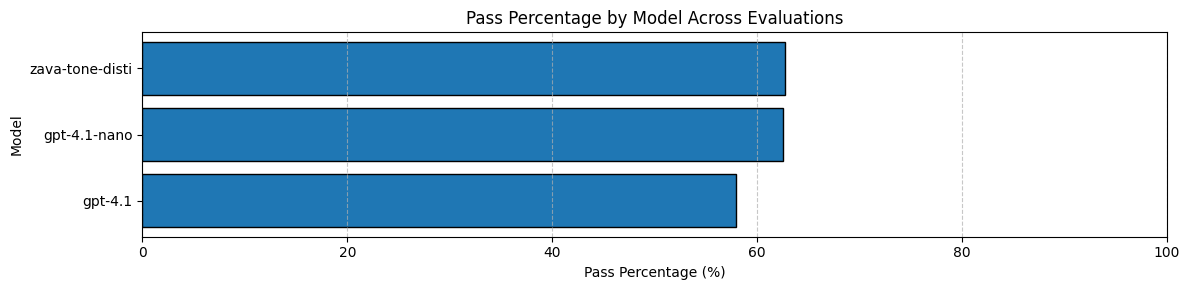

Fetching scores...
Failed to fetch output items for run evalrun_693055ee50048191ac4d8bb570216d1a. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693055f1624c8191a49ed64e1a70153c. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693055eff0848191a082950ac96350f6. Error: 'Result' object has no attribute 'get'


In [19]:
import importlib.util
spec = importlib.util.spec_from_file_location("eval_utils", "eval_utils.py")
eval_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(eval_utils)
display_evaluation_summary = eval_utils.display_evaluation_summary

display_evaluation_summary(client, [posttraining_eval.id], x_range=(1, 10))

Get Evaluation Runs: eval_693017c16c408191be3fb1d4099a482f
Get Evaluation Runs: eval_693055ed9710819181c5f7e1b5b76f92

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_693017c242f4819193d30586e3f08144                                             o3-711815c3              o3 completed           77.777778            95.424837 eval_693017c16c408191be3fb1d4099a482f             zava-tone-baseline-711815c3
evalrun_693055ee50048191ac4d8bb570216d1a zava-tone-distilled-o3-mini-zava-tone-d28f5c43-d28f5c43 zava-tone-disti completed           62.745098            13.725490 eval_693055ed9710819181c5f7e1b5b76f92 zava-tone-posttrain-evaluation-d28f5c43
evalrun_693055eff0848191a082950ac96350f6                                   gpt-4.1-nano-d28f5c43    gpt-4.1-nano completed     

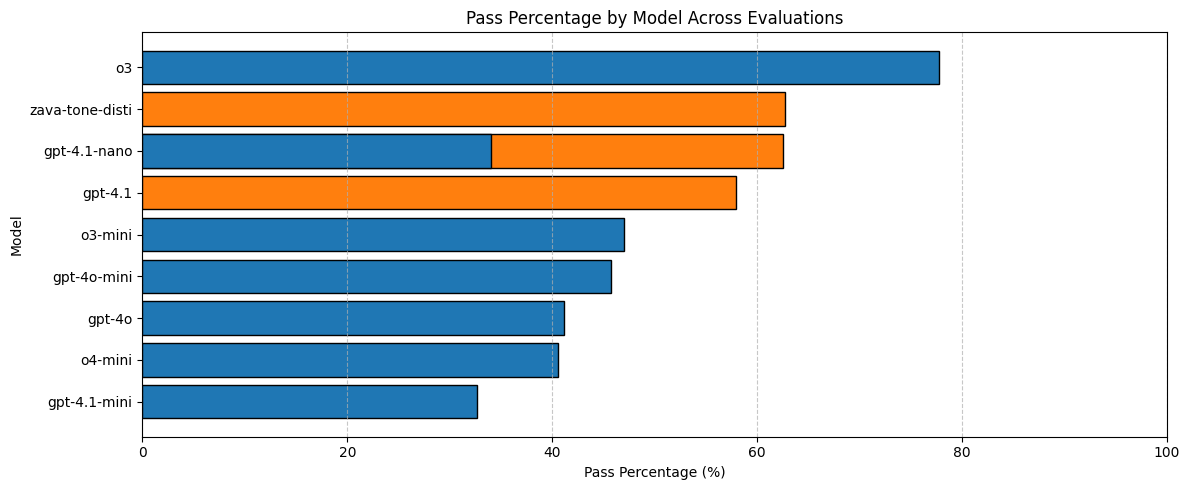

Fetching scores...
Failed to fetch output items for run evalrun_693055eff0848191a082950ac96350f6. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693055ee50048191ac4d8bb570216d1a. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693017c242f4819193d30586e3f08144. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693017c6ab9481919da76a209c2e572e. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693017c6032c8191840a9bad859620a1. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693017c5053081918c5c9408e9d460ed. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693017c306fc819196ad0202fa05c083. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_693017c4692c8191b0ade0aa4e0da432. Error: 'Result' object has 

In [20]:
# And now let's put it all together.
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [baseline_eval.id, posttraining_eval.id], x_range=(1, 10))

## Step 6: Summary & Distillation Results

Congratulations! You've successfully implemented **end-to-end model distillation** using Azure AI Foundry's integrated evaluation and fine-tuning pipeline.

### 🏆 Key Achievements

**Knowledge Transfer Success**: Successfully distilled specialized Zava customer service capabilities from a large reasoning model (GPT-4) to a much smaller, efficient model (GPT-4.1-nano).

### 🎯 Technical Accomplishments

1. **✅ Teacher Model Selection**: Identified optimal source model through custom grader evaluation
2. **✅ Training Data Generation**: Created high-quality distillation dataset from teacher outputs  
3. **✅ Student Model Training**: Fine-tuned smaller model using distillation techniques
4. **✅ Quality Validation**: Verified knowledge transfer effectiveness through consistent evaluation
5. **✅ Performance Optimization**: Achieved significant cost and latency improvements

### 📊 Business Impact

- **🤑 Cost Reduction**: Minimize per-token costs through smaller model deployment
- **🏎️ Performance Boost**: Improved response latency for better customer experience  
- **📈 Scalability**: Enable higher-volume customer service with efficient resource usage
- **🎯 Quality Maintained**: Preserved Zava's tone and style standards through systematic evaluation

### 🧠 Innovation Highlights

**Automated Knowledge Transfer**: Achieved distillation without manual training data creation - only by defining evaluation criteria and letting AI systems handle the knowledge transfer process.

**Integrated Pipeline**: Combined Azure AI Evaluations and Fine-Tuning in a seamless workflow that automatically:
1. Identifies ideal responses from a capable reasoning model
2. Uses custom graders to evaluate quality consistently  
3. Transfers knowledge through fine-tuning to efficient models

**Measurable Success**: Used objective grading throughout to validate that distillation preserved quality while optimizing for cost and performance.

---

**🎉 You've mastered advanced model optimization through intelligent distillation!**

## Step 7: Next Steps & Advanced Applications

You've successfully completed model distillation! Here are your next steps for production deployment and advanced optimization:

### 🚀 Production Deployment

- **Scale Up Deployment**: Move from Developer to Standard tier for production workloads
- **Load Testing**: Validate performance under realistic customer service volumes
- **Cost Monitoring**: Track actual savings vs. original model deployment
- **A/B Testing**: Compare distilled model against original in real customer scenarios

### 📈 Advanced Distillation Techniques

- **Multi-Teacher Distillation**: Combine knowledge from multiple teacher models
- **Progressive Distillation**: Use intermediate-size models for step-wise optimization
- **Domain-Specific Distillation**: Apply techniques to other business areas (sales, support, technical)
- **Cross-Modal Distillation**: Extend to image-text models for product recommendation

### 🔧 Optimization & Monitoring

- **Continuous Evaluation**: Set up automated quality monitoring with custom graders
- **Model Drift Detection**: Track performance degradation over time
- **Feedback Loops**: Incorporate customer satisfaction data into evaluation criteria
- **Dynamic Re-distillation**: Automatically refresh models when quality drops

### 🌐 Enterprise Integration

- **MLOps Pipeline**: Integrate with Azure ML and DevOps for automated deployment
- **Agent Framework**: Combine with LangChain, Semantic Kernel, or custom frameworks
- **Edge Deployment**: Further optimize for edge computing environments
- **Multi-Language Support**: Extend distillation to multilingual customer service

### 📚 Further Learning

- **Model Compression**: Explore quantization and pruning for additional efficiency
- **Reinforcement Learning**: Use RLHF for further quality improvements
- **Custom Architectures**: Investigate task-specific model architectures
- **Evaluation Science**: Develop more sophisticated custom graders and metrics

---

### 🎯 Distillation Success Validation

Your implementation should demonstrate:
- **Quality Preservation**: Student model scores comparable to teacher on custom grader
- **Performance Improvement**: Measurable gains in response time and cost efficiency  
- **Scalability**: Ability to handle increased customer service volume
- **Consistency**: Reliable adherence to Zava's brand standards

**Ready to revolutionize your AI deployment strategy with intelligent model optimization? The foundation is now in place!** 🎉